# Example of usage

In [24]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load required libraries

In [25]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray, gap_fill, plot_image, to_netcdf
import matplotlib.pyplot as plt


Set up some variables and load an example minicube

In [26]:
array_id= '-111.49_38.60'
input_path= 'mc_-111.49_38.60_1.2.2_20230702_0.zarr'
output_path= './out'

In [27]:
minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
minicube['cloudmask_en']= minicube['cloudmask_en'].astype(np.uint8)
minicube= minicube.drop_vars('B07') #We drop a variable for now

In [28]:
minicube

<xarray.Dataset>
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
Data variables: (12/37)
    B02           (time, y, x) float32 ...
    B03           (time, y, x) float32 ...
    B04           (time, y, x) float32 ...
    B05           (time, y, x) float32 ...
    B06           (time, y, x) float32 ...
    B8A           (time, y, x) float32 ...
    ...            ...
    t2m_max       (time) float32 ...
    t2m_mean      (time) float32 ...
    t2m_min       (time) float32 ...
    tp_max        (time) float32 ...
    tp_mean       (time) float32 ...
    tp_min        (time) float32 ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Fix the small jitter betweeen timesteps to improve compression

In [29]:
import satalign

#Reload minicube for testing
minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
minicube= minicube.drop_vars('B07') #We drop a variable for now

bands= ['B04','B03','B02','B8A','B06','B05']
reference_image= minicube[bands].isel(time=slice(74,None)).mean("time").to_array().transpose('variable', 'y', 'x')
datacube= minicube[bands].to_array().transpose('time', 'variable', 'y', 'x')

syncmodel= satalign.PCC( #PCC quicker, ECC more precise
    datacube=datacube, # T x C x H x W
    reference=reference_image, # C x H x W
    channel="mean", crop_center=96, num_threads=1)
new_cube, warps= syncmodel.run_multicore()

/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/satalign/pcc.py:78: UserWarning: Could not determine RMS error between images with the normalized average intensities 9214516.0 and 0.0. Either the reference or moving image may be empty.
  shift, error, diffphase = phase_cross_correlation(
/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/satalign/main.py:227: UserWarning: Estimated translation is too large
  warnings.warn("Estimated translation is too large")


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

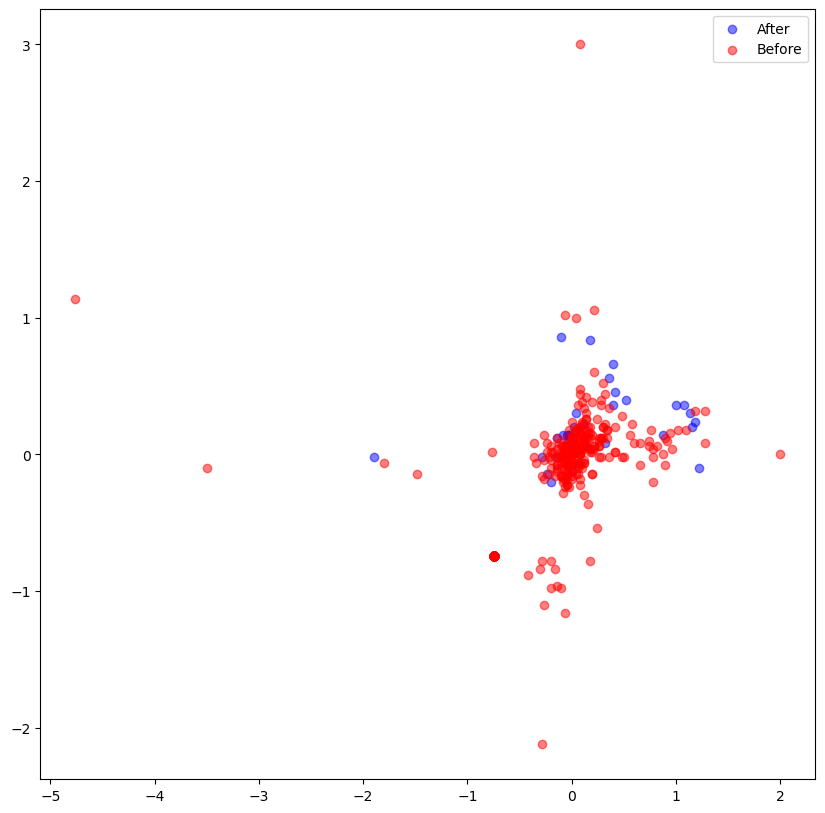

In [30]:
#Plot scatter plot
warp_df = satalign.utils.warp2df(warps, datacube.time.values)
satalign.utils.plot_s2_scatter(warp_df)

In [31]:
#Copy back
for b in bands:
    minicube[b]= new_cube.sel(variable=b)

Gap-fill in clouds

For now, we won't apply gap-filling of the clouds, since it is too big of a change to the data. If a good gap-filling algorithm were to be used, we could save up much more space when converting to video

In [32]:
#Perform the gap filling. Three methods: last_value, interp_forward, interp (non-causal!!)
minicube_filled= gap_fill(minicube, fill_bands=bands, mask_band='cloudmask_en',
                          fill_values=[1, 3, 4], method='last_value', new_mask='invalid', 
                          coord_names=('time', 'variable', 'x', 'y'))

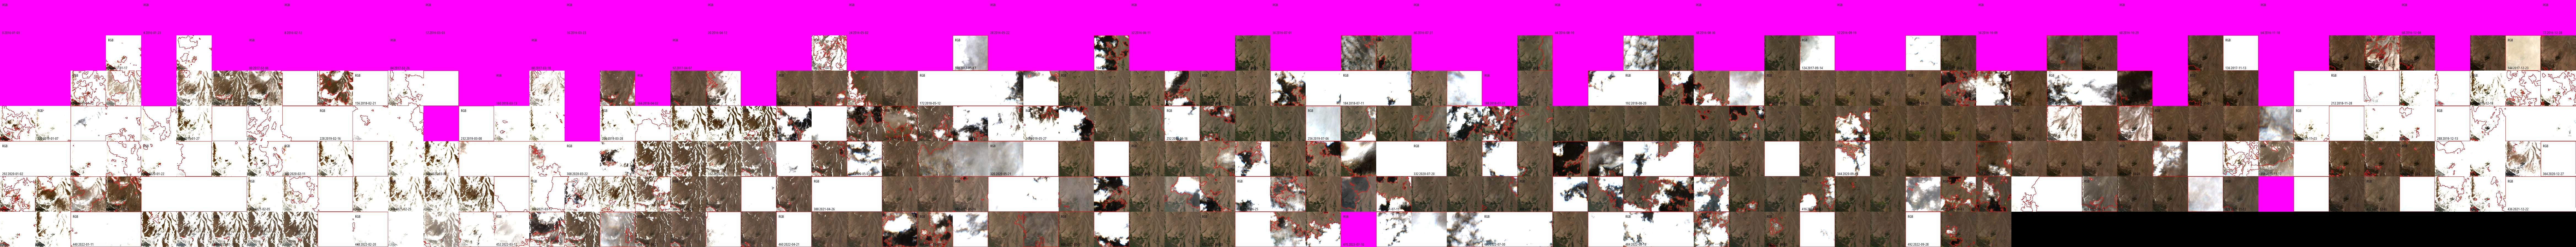

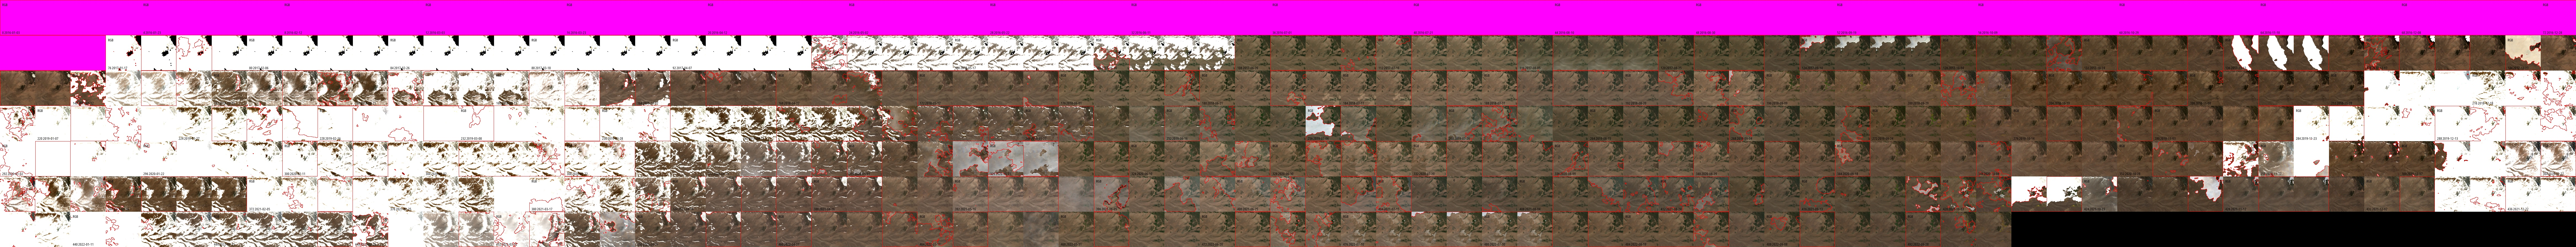

In [33]:
#RGB orig
plot_image(minicube, ['B04','B03','B02'], mask_name='cloudmask_en', save_name='./out/RGB original.jpg')

#RGB gap-filled
plot_image(minicube_filled, ['B04','B03','B02'], mask_name='invalid', save_name='./out/RGB gap-filled.jpg')

Define conversion rules for the different bands. The syntax is:
```
'video_name': ( 
    var or (var1, var2, var3), #Variables present in the xarray
    (t_coord_name, x_coord_name, y_coord_name), #Names of the coordinates in order (t, x, y)
    'lossy' or 'lossless' #compression (e.g. lossless for uint8 masks)
    ),
...
```

In [34]:
minicube

<xarray.Dataset>
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
    variable      <U3 'B04'
Data variables: (12/37)
    B02           (time, y, x) float32 0.0 0.0 0.0 ... 0.06185 0.06106 0.06242
    B03           (time, y, x) float32 0.0 0.0 0.0 ... 0.08014 0.07839 0.0823
    B04           (time, y, x) float32 0.0 0.0 0.0 ... 0.09636 0.09845 0.1036
    B05           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1155 0.1171 0.1222
    B06           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1332 0.1409 0.1453
    B8A           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.156 0.1662 0.1658
    ...            ...
    t2m_max       (time) float32 ...
    t2m_mean      (time) float32 ...
    t2m_min       (time) float32 ...
    tp_max        (time) float32 ...
    tp_mean       (time) float32 ...
    tp_min        (time) float32 ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

In [35]:
#Define conversion rules for the different bands
conversion_rules= {
    # 'r': ( 'B04', ('time','x','y'), 'lossy'), #1 channel + lossy not working
    # 'ir4': ( ('B8A','B07','B06','B05'), ('time','x','y'), 'lossy'), #4 channels not working
    'rgb': ( ('B04','B03','B02'), ('time','x','y'), 'lossy'),
    'ir3': ( ('B8A','B06','B05'), ('time','x','y'), 'lossy'),
    'cm': ( 'cloudmask_en', ('time','x','y'), 'lossless'),
    'scl': ( 'SCL', ('time','x','y'), 'lossless'),
    }

Compress and write new file

If you get `ContainsGroupError`, make sure to delete the existing `out` folder:

In [36]:
#Remove out folder to avoid errors
!rm -rf ./out

rm: no se puede borrar './out/-111.49_38.60': El directorio no está vacío


In [37]:
#Save original minicube for comparing the size (it will be compressed)
Path(output_path).mkdir(exist_ok=True, parents=True)
#minicube.to_zarr(Path(output_path) / f'{array_id}.zarr')
to_netcdf(minicube, Path(output_path) / f'{array_id}.nc')

In [40]:
#Define the output video encoding parameters
#Lossless
lossless_params= {'vcodec':'ffv1'}

#Lossy
lossy_params = {
    'c:v': 'libx264',  #libx264 always seems better for rgb[libx264, libx265, vp9, ffv1]
    'preset': 'slow',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': 11, #14 default, 11 for higher quality and size
    }

#Run with compute_stats (takes a bit longer). Activating `use_ssim` takes even longer
arr_dict= xarray2video(minicube, array_id, conversion_rules, value_range=(0.,1.),
                       lossy_params=lossy_params, lossless_params=lossless_params, fmt='mkv',
                       output_path=output_path, use_ssim=True, compute_stats=True,
                       loglevel='quiet', #verbose, quiet
                       )  

rgb: 23.20Mb -> 0.95Mb (4.11% of original size) in 1.09s
 - params={'c:v': 'libx264', 'preset': 'slow', 'crf': 11, 'pix_fmt': 'rgb24', 'r': 30}
 - SSIM_sat 0.998597 (input saturated to [(0.0, 1.0)])
 - MSE_sat 0.000055 (input saturated to [(0.0, 1.0)])
ir3: 23.20Mb -> 0.93Mb (4.01% of original size) in 1.15s
 - params={'c:v': 'libx264', 'preset': 'slow', 'crf': 11, 'pix_fmt': 'rgb24', 'r': 30}
 - SSIM_sat 0.998346 (input saturated to [(0.0, 1.0)])
 - MSE_sat 0.000064 (input saturated to [(0.0, 1.0)])
cm: 7.73Mb -> 0.08Mb (0.98% of original size) in 0.12s
 - params={'vcodec': 'ffv1', 'pix_fmt': 'gray', 'r': 30}
 - acc 1.00
scl: 7.73Mb -> 0.29Mb (3.70% of original size) in 0.11s
 - params={'vcodec': 'ffv1', 'pix_fmt': 'gray', 'r': 30}
 - acc 1.00


Compute total size, and observe a signficant compression rate (~20x)

In [ ]:
original_path= str(Path(output_path) / f'{array_id}.nc')
!du -h {original_path} -d0

In [ ]:
new_path= str(Path(output_path) / f'{array_id}')
!du -h {new_path} 

Read again the written file, and check that everything has persisted

In [ ]:
minicube_new= video2xarray(output_path, array_id, fmt='mkv') 
minicube_new

Visualize results

In [ ]:
#RGB orig
plot_image(minicube, ['B04','B03','B02'], save_name='./out/RGB original.jpg')

#RGB compressed
plot_image(minicube_new, ['B04','B03','B02'], save_name='./out/RGB compressed.jpg')

In [ ]:
#R3 original
#plot_image(minicube, ['B8A','B06','B05'], save_name='R3 original.jpg')

#R3 compressed
#plot_image(minicube_new, ['B8A','B06','B05'], save_name='R3 compressed.jpg')

In [ ]:
#RGBA compressed
# txy_real_rgba_compressed= np.transpose(arr_dict['ir4'][0], (3,0,1,2)) #t,x,y,3 -> 4,t,x,y
# img_comp= plot_txy(txy_real_rgba_compressed, txy_mask, t, [[0],[1],[2],[3]], ['B8A','B07','B06','B05'], 
#                    title='RGBA Compressed', select=slice(None,None,1), plot_mask=False)
# cv2.imwrite(f'img_com_rgba.jpg', img_comp[...,[2,1,0]])

Watch as a video (some formats might not be supported)

In [ ]:
from IPython.display import Video, display, HTML, Image
for video in conversion_rules.keys():
    display(HTML(f'<h4>{video}</h4>'))
    display(Video(Path(output_path) / array_id / f'{video}.mkv', width=512, height=512))